<a href="https://colab.research.google.com/github/andrewcampos1/Simulaciones/blob/main/SimMC_Mantenimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importar las librerías necesarias
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

# Autenticación
auth.authenticate_user()
creds, _ = default()

# Conectar a Google Sheets
client = gspread.authorize(creds)

# Abrir la hoja de Google Sheets mediante su URL
sheet_url = 'a://docs.google.com`/spreadsheets/d/1NywOqhWgan8QXJNp0wqwH0CUaiFXQbJLhl42GJn8Ibw/edit?gid=0#gid=0'  # Reemplaza con la URL de tu hoja de Google Sheets
sheet = client.open_by_url(sheet_url).sheet1  # Selecciona la primera hoja (sheet1)

# Obtener los datos de la hoja de cálculo en formato de lista de diccionarios
data = sheet.get_all_records()

# Convertir los datos en un DataFrame de pandas
df = pd.DataFrame(data)

# Función para limpiar los valores de euros y convertir a numérico
def limpiar_euros(val):
    if isinstance(val, str):
        # Remover el símbolo de € y cualquier espacio
        val = val.replace('€', '').replace(',', '').strip()
        # Intentar convertir a número
        try:
            return float(val)
        except ValueError:
            return val  # Devolver el valor original si no se puede convertir
    return val

# Aplicar la función de limpieza a todas las columnas del DataFrame
df = df.applymap(limpiar_euros)

# Mostrar el DataFrame
df.head()  # Mostrar las primeras filas del DataFrame


<ipython-input-5-efd4c6cdadf7>:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(limpiar_euros)


,Item,Valor_Minimo,Valor_Probable,Valor_Maximo
0,Alimento,1.012.500,1.125.000,1.237.500
1,Transporte_Op,400.0,500.0,550.0
2,Transporte_Sup,66.667,333.333,333.333
3,Alojamiento_Sup,2.555.000,3.650.000,3.832.500
4,Seguros,1.159.950,1.221.000,1.245.420


In [ ]:
import numpy as np
import pandas as pd

# Supongamos que 'df' ya está cargado y conectado a Google Sheets

# Convertir a string si no es tipo object
for col in ['Valor_Minimo', 'Valor_Probable', 'Valor_Maximo']:
    if df[col].dtype != 'object':
        df[col] = df[col].astype(str)

# Reemplazar separadores de miles y convertir a numérico
df['Valor_Minimo'] = df['Valor_Minimo'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['Valor_Probable'] = df['Valor_Probable'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['Valor_Maximo'] = df['Valor_Maximo'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)

# Convertir las columnas a formato numérico
df['Valor_Minimo'] = pd.to_numeric(df['Valor_Minimo'], errors='coerce')
df['Valor_Probable'] = pd.to_numeric(df['Valor_Probable'], errors='coerce')
df['Valor_Maximo'] = pd.to_numeric(df['Valor_Maximo'], errors='coerce')

# Eliminar filas con valores NaN en las columnas de interés
df = df.dropna(subset=['Valor_Minimo', 'Valor_Probable', 'Valor_Maximo'])

# Paso 2: Definir la función para generar valores PERT
def pert_rnd(valor_minimo, valor_probable, valor_maximo, lamb=4, size=1):
    """Genera valores aleatorios según la distribución PERT."""
    delta = valor_maximo - valor_minimo
    delta[delta == 0] = 1e-6  # Reemplazar cero por un pequeño número para evitar división por cero

    alpha = 1 + lamb * (valor_probable - valor_minimo) / delta
    beta = 1 + lamb * (valor_maximo - valor_probable) / delta

    # Generar valores aleatorios de la distribución beta
    return np.random.beta(alpha, beta, size=size) * delta + valor_minimo

# Paso 3: Función para realizar la simulación de Monte Carlo
def simulacion_montecarlo(df, iteraciones=10000):
    resultados_totales = []
    iteracion_ejemplo = 5  # Ejemplo de iteración a mostrar

    # Excluir la primera fila (títulos) y la primera columna (clasificación)
    for i in range(iteraciones):
        # Generar muestras aleatorias para cada fila
        muestras = pert_rnd(
            df['Valor_Minimo'].values,
            df['Valor_Probable'].values,
            df['Valor_Maximo'].values,
            lamb=4,
            size=len(df)  # Generar una muestra por cada fila
        )

        # Sumar los costos simulados
        costo_total = np.sum(muestras)  # Sumar todos los valores de la muestra
        resultados_totales.append(costo_total)  # Agregar el costo total a la lista

        # Mostrar los valores generados en la iteración de ejemplo
        if i == iteracion_ejemplo - 1:  # Restar 1 porque las iteraciones empiezan desde 0
            print(f"Iteración {iteracion_ejemplo}:")
            for j, valor in enumerate(muestras):
                print(f"  Costo para item {j+1}: {valor:.2f}")
            print(f"  Costo Total: {costo_total:.2f}\n")

    # Convertir resultados a DataFrame
    resultados_df = pd.DataFrame({'Costo_Total': resultados_totales})
    return resultados_df

# Paso 4: Ejecutar la simulación
resultados_df = simulacion_montecarlo(df)

# Verificar la media del costo total
media_costo_total = resultados_df['Costo_Total'].mean()
print(f"Media del Costo Total: {media_costo_total:.2f}")

# Mostrar estadísticas descriptivas del resultado
print(resultados_df.describe())


Iteración 5:
  Costo para item 1: 1096566.49
  Costo para item 2: 3561371.10
  Costo para item 3: 1228091.07
  Costo para item 4: 7926054.00
  Costo para item 5: 1949854.78
  Costo para item 6: 11899306.92
  Costo para item 7: 17132418.97
  Costo Total: 44793663.33

Media del Costo Total: 44104838.01
        Costo_Total
count  1.000000e+04
mean   4.410484e+07
std    5.391096e+06
min    2.870084e+07
25%    4.065389e+07
50%    4.333440e+07
75%    4.708943e+07
max    6.907008e+07


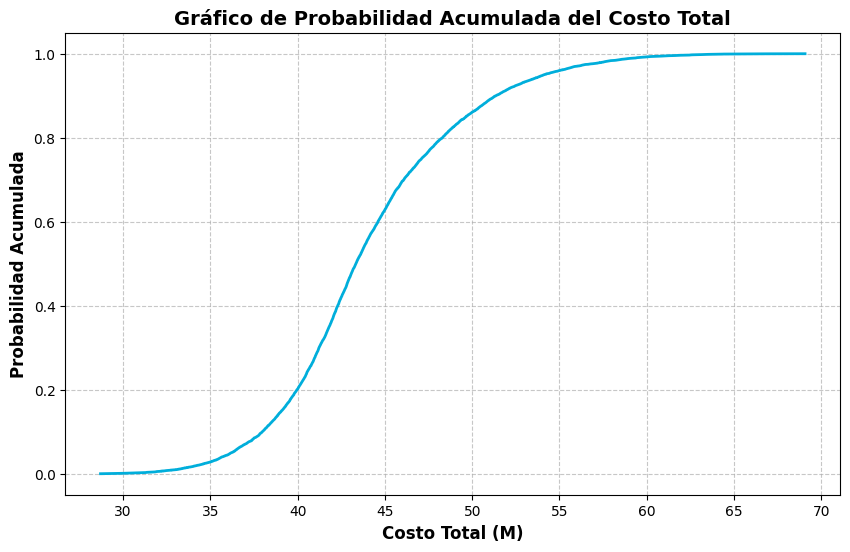

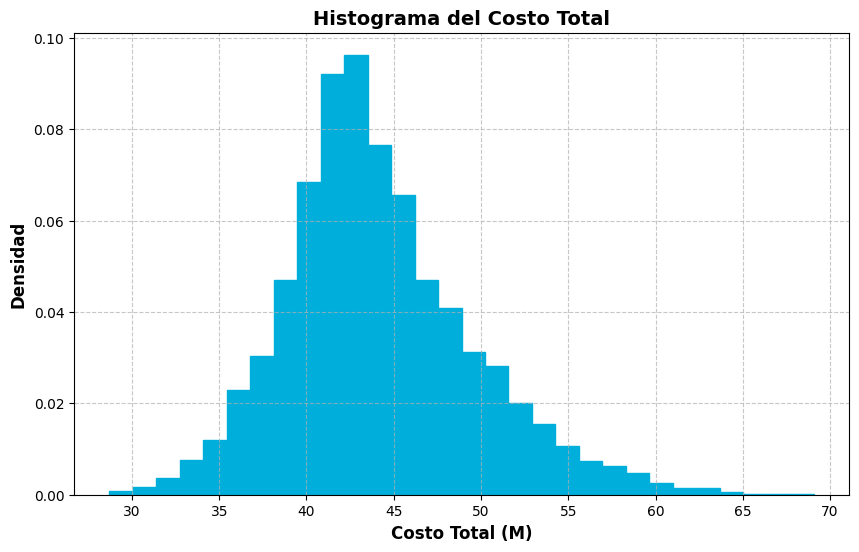

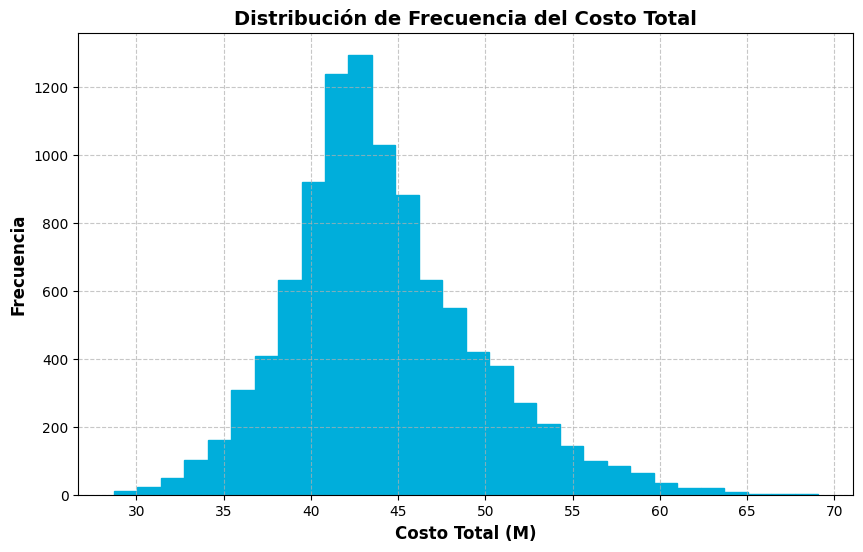

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def crear_graficos_estilo_mckinsey(df, columna):
    """
    Crea gráficos de probabilidad acumulada, histograma y distribución de frecuencia con estilo similar a McKinsey.

    Args:
        df: El DataFrame con los datos.
        columna: La columna a graficar.
    """

    # Paleta de colores inspirada en McKinsey (ajusta según tus preferencias)
    colors = ['#00AEDB', '#00AEDB', '#00AEDB']

    # Gráfico de probabilidad acumulada
    plt.figure(figsize=(10, 6))
    plt.plot(np.sort(df[columna])/1e6, np.arange(len(df)) / len(df), color=colors[0], linewidth=2)
    plt.xlabel('Costo Total (M)', fontsize=12, fontweight='bold')
    plt.ylabel('Probabilidad Acumulada', fontsize=12, fontweight='bold')
    plt.title('Gráfico de Probabilidad Acumulada del Costo Total', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Histograma
    plt.figure(figsize=(10, 6))
    plt.hist(df[columna]/1e6, bins=30, color=colors[1], edgecolor=colors[2], density=True)
    plt.xlabel('Costo Total (M)', fontsize=12, fontweight='bold')
    plt.ylabel('Densidad', fontsize=12, fontweight='bold')
    plt.title('Histograma del Costo Total', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Gráfico de distribución de frecuencia
    plt.figure(figsize=(10, 6))
    plt.hist(df[columna]/1e6, bins=30, color=colors[1], edgecolor=colors[2])
    plt.xlabel('Costo Total (M)', fontsize=12, fontweight='bold')
    plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
    plt.title('Distribución de Frecuencia del Costo Total', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Llamada a la función con la columna 'Costo_Total'
crear_graficos_estilo_mckinsey(resultados_df, 'Costo_Total')

**esto es un mkdw** deberia aparecer en git